<a href="https://colab.research.google.com/github/nkgupta16/AAI_LAB1/blob/main/AAI_LAB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практическая работа №3. Свёрточные нейронные сети

**Работу выполнил (а):**

Гупта Нилеш Кумар, 374371, Прик ИИ R23 бак 2.3

# Классификация цветов с помощью свёрточных нейронных сетей.


В работе необходимо познакомится с различными архитектурами сверхточных нейронных сетей и их обучением на GPU (англ. graphics processing, графический процессор) на языке программирования Python 3 и фреймворка Torch (PyTorch).  Для этого предлагается использовать ресурсы Google Colab - Colaboratory, для выполнения вычислений на GPU. После с ознакомления, выполнить практическое задане в конце данной тетради (notebook).

Рассмотрим [Датасет](https://www.kaggle.com/alxmamaev/flowers-recognition ) содержащий 4242 изображения цветов размеченных по 5 видам (тюльпан, ромашка, подсолнух, роза, одуванчик). Данный набор данных можно скачать по [ссылке](https://www.kaggle.com/alxmamaev/flowers-recognition ) с сайте kaggle.

Загрузите папку с картинками на гугл диск, чтобы не загружать ее каждый раз заново при перезапуске колаба. Структура файлов (можно посмотреть в меню слева) может быть такой: "/content/drive/My Drive/data/flowers".

Обязательно подключите аппаратный ускоритель (GPU) к среде выполнения. В меню сверху: Среда выполнения -> Сменить среду выполнения

Первым делом разберите более детально код выполнив код ниже.

# Подготовка

Загружаем библиотеки. Фиксируем random.seed для воспроизводимости

In [ ]:
import numpy as np
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

random.seed(0)
torch.manual_seed(0)

Выбираем на чем будем делать вычисления - CPU или GPU (cuda)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Блок для соединения с Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/colab_repos/lab3
!ls -la

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/colab_repos/lab3
total 43776
-rw------- 1 root root    24730 Dec 17 11:56 AAI_LAB3.ipynb
drwx------ 7 root root     4096 Dec  7 22:39 flowers
-rw------- 1 root root 44796683 Dec  8 03:09 resnet18_flowers.pth


In [ ]:
FOLDERNAME = 'flowers'

assert FOLDERNAME is not None, "[!] Enter the foldername."

#%cd drive/My\ Drive
#%cp -r $FOLDERNAME ../../
#%cd ../../
#%cd data/flowers/
#!bash get_datasets.sh
#%cd ../../

#+For kaggle______________________________________________
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# FOLDERNAME = '/kaggle/input/flowers-recognition/flowers'
# %cd /kaggle/input/flowers-recognition/flowers

In [ ]:
prepare_imgs = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)), #приводим картинки к одному размеру
        torchvision.transforms.ToTensor(), # упаковывем их в тензор
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] # нормализуем картинки по каналам
        ),
    ]
)
# задаем датасет. Лейблы - имена папок:
dataset = ImageFolder('/content/drive/MyDrive/colab_repos/lab3/flowers', transform=prepare_imgs)

In [ ]:
dataset.imgs[2]

('/content/drive/MyDrive/colab_repos/lab3/flowers/daisy/10172379554_b296050f82_n.jpg',
 0)

In [ ]:
class ValueMeter(object):
  """
  Вспомогательный класс, чтобы отслеживать loss и метрику
  """
  def __init__(self):
      self.sum = 0
      self.total = 0

  def add(self, value, n):
      self.sum += value*n
      self.total += n

  def value(self):
      return self.sum/self.total

def log(mode, epoch, loss_meter, accuracy_meter, best_perf=None):
  """
  Вспомогательная функция, чтобы
  """
  print(
      f"[{mode}] Epoch: {epoch:0.2f}. "
      f"Loss: {loss_meter.value():.2f}. "
      f"Accuracy: {100*accuracy_meter.value():.2f}% ", end="\n")

  if best_perf:
      print(f"[best: {best_perf:0.2f}]%", end="")


# Сверточная нейросеть с нуля

## Вручную прописываем слои

In [ ]:
model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
model.to(device) # отправляем модель на девайс (GPU)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=200704, out_features=1024, bias=True)
  (17): ReLU()
  (18): Linear(in_features=1024, out_features=512, bias=True)
  (19): ReLU()
  (20): Lin

Задаем гиперпараметры для обучения:

# Задаем параметры и функцию для обучения. Разбиваем датасет на train/validation

In [ ]:
batch_size = 32
optimizer = torch.optim.Adam(params = model.parameters())
lr = 0.001

Разбиваем датасет на train и validation

Задаем dataloader'ы - объекты для итеративной загрузки данных и лейблов для обучения и валидации

In [ ]:
train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-1000, 1000])
print('Размер обучающего и валидационного датасета: ', len(train_set), len(val_set))
loaders = {'training': DataLoader(train_set, batch_size, pin_memory=True,num_workers=2, shuffle=True),
           'validation':DataLoader(val_set, batch_size, pin_memory=True,num_workers=2, shuffle=False)}

Размер обучающего и валидационного датасета:  3328 1000


Функция для подсчета Accuracy

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Функция для обучения и валидации модели

In [ ]:
def trainval(model, loaders, optimizer, epochs=10):
    """
    model: модель, которую собираемся обучать
    loaders: dict с dataloader'ами для обучения и валидации
    """
    loss_meter = {'training': ValueMeter(), 'validation': ValueMeter()}
    accuracy_meter = {'training': ValueMeter(), 'validation': ValueMeter()}

    loss_track = {'training': [], 'validation': []}
    accuracy_track = {'training': [], 'validation': []}

    for epoch in range(epochs): # итерации по эпохам
        for mode in ['training', 'validation']: # обучение - валидация
            # считаем градиаент только при обучении:
            with torch.set_grad_enabled(mode == 'training'):
                # в зависимоти от фазы переводим модель в нужный ружим:
                model.train() if mode == 'training' else model.eval()
                for imgs, labels in tqdm(loaders[mode]):
                    imgs = imgs.to(device) # отправляем тензор на GPU
                    labels = labels.to(device)
                    bs = labels.shape[0]  # размер батча (отличается для последнего батча в лоадере)

                    preds = model(imgs) # forward pass - прогоняем тензор с картинками через модель
                    loss = F.cross_entropy(preds, labels) # считаем функцию потерь
                    acc = accuracy(preds, labels) # считаем метрику

                    # храним loss и accuracy для батча
                    loss_meter[mode].add(loss.item(), bs)
                    accuracy_meter[mode].add(acc, bs)

                    # если мы в фазе обучения
                    if mode == 'training':
                        optimizer.zero_grad() # обнуляем прошлый градиент
                        loss.backward() # делаем backward pass (считаем градиент)
                        optimizer.step() # обновляем веса
            # в конце фазы выводим значения loss и accuracy
            log(mode, epoch, loss_meter[mode], accuracy_meter[mode])

            # сохраняем результаты по всем эпохам
            loss_track[mode].append(loss_meter[mode].value())
            accuracy_track[mode].append(accuracy_meter[mode].value())
    return loss_track, accuracy_track

# Обучаем базовую модель

Проверим загрузку видеокарты, прежде чем запустить обучение:

Запускаем обучение на 10 эпох

In [ ]:
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs=10)

100%|██████████| 104/104 [00:34<00:00,  2.99it/s]


[training] Epoch: 0.00. Loss: 1.49. Accuracy: 30.92% 


100%|██████████| 32/32 [00:07<00:00,  4.48it/s]


[validation] Epoch: 0.00. Loss: 1.34. Accuracy: 38.50% 


100%|██████████| 104/104 [00:34<00:00,  3.05it/s]


[training] Epoch: 1.00. Loss: 1.39. Accuracy: 37.62% 


100%|██████████| 32/32 [00:06<00:00,  4.86it/s]


[validation] Epoch: 1.00. Loss: 1.27. Accuracy: 43.65% 


100%|██████████| 104/104 [00:34<00:00,  3.06it/s]


[training] Epoch: 2.00. Loss: 1.32. Accuracy: 41.93% 


100%|██████████| 32/32 [00:07<00:00,  4.41it/s]


[validation] Epoch: 2.00. Loss: 1.21. Accuracy: 47.07% 


100%|██████████| 104/104 [00:33<00:00,  3.06it/s]


[training] Epoch: 3.00. Loss: 1.24. Accuracy: 45.73% 


100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


[validation] Epoch: 3.00. Loss: 1.18. Accuracy: 48.25% 


100%|██████████| 104/104 [00:33<00:00,  3.07it/s]


[training] Epoch: 4.00. Loss: 1.16. Accuracy: 50.53% 


100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


[validation] Epoch: 4.00. Loss: 1.18. Accuracy: 50.62% 


100%|██████████| 104/104 [00:34<00:00,  3.05it/s]


[training] Epoch: 5.00. Loss: 1.05. Accuracy: 55.55% 


100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


[validation] Epoch: 5.00. Loss: 1.23. Accuracy: 51.98% 


100%|██████████| 104/104 [00:33<00:00,  3.06it/s]


[training] Epoch: 6.00. Loss: 0.96. Accuracy: 60.11% 


100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


[validation] Epoch: 6.00. Loss: 1.32. Accuracy: 53.41% 


100%|██████████| 104/104 [00:33<00:00,  3.07it/s]


[training] Epoch: 7.00. Loss: 0.86. Accuracy: 64.21% 


100%|██████████| 32/32 [00:07<00:00,  4.25it/s]


[validation] Epoch: 7.00. Loss: 1.48. Accuracy: 53.79% 


100%|██████████| 104/104 [00:34<00:00,  3.05it/s]


[training] Epoch: 8.00. Loss: 0.78. Accuracy: 67.72% 


100%|██████████| 32/32 [00:06<00:00,  4.88it/s]


[validation] Epoch: 8.00. Loss: 1.61. Accuracy: 54.49% 


100%|██████████| 104/104 [00:34<00:00,  3.05it/s]


[training] Epoch: 9.00. Loss: 0.71. Accuracy: 70.71% 


100%|██████████| 32/32 [00:06<00:00,  5.00it/s]

[validation] Epoch: 9.00. Loss: 1.80. Accuracy: 54.83% 


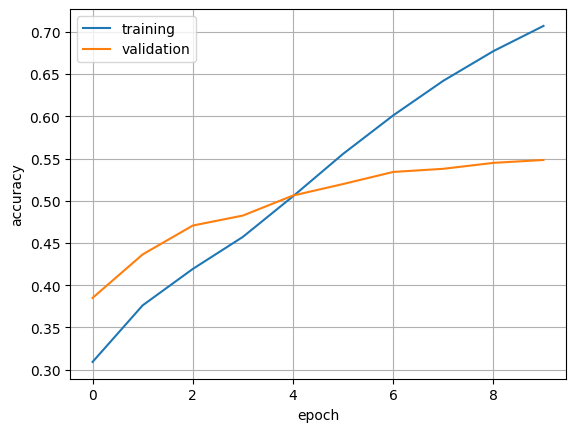

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

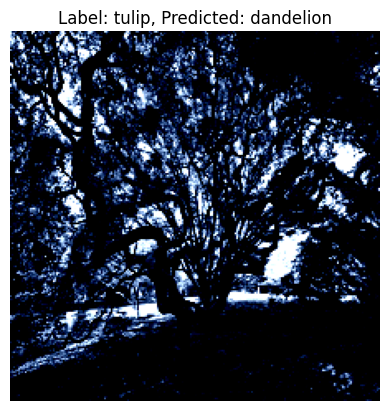

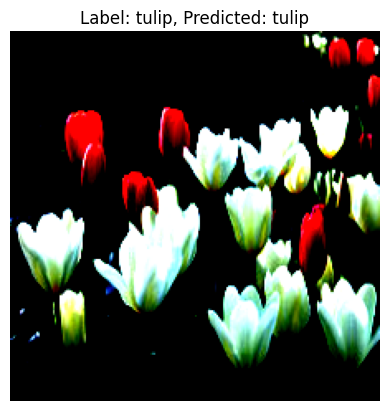

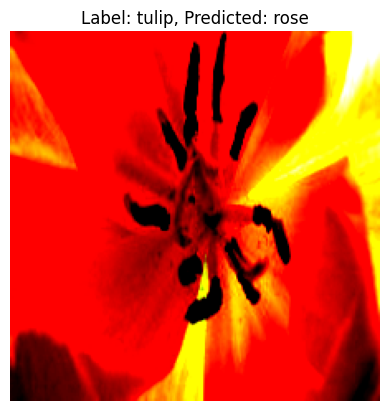

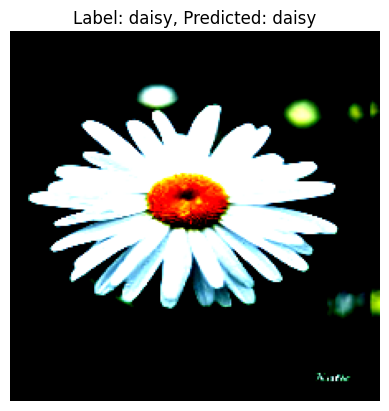

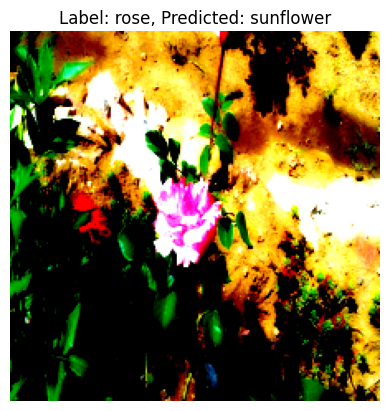

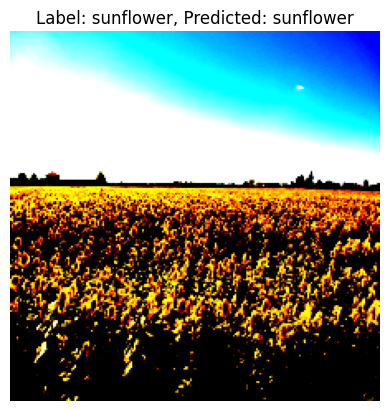

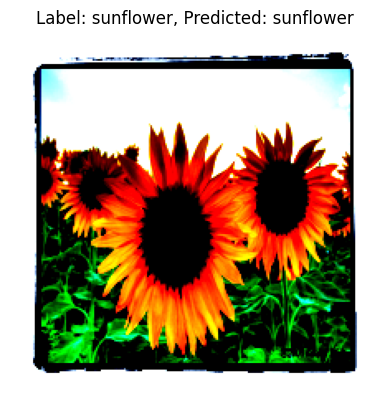

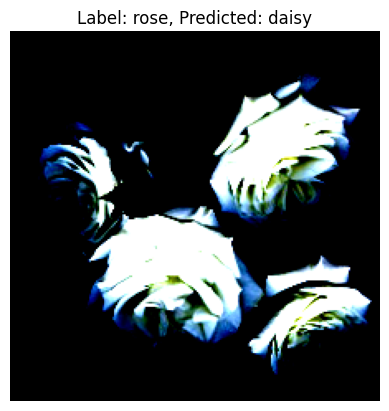

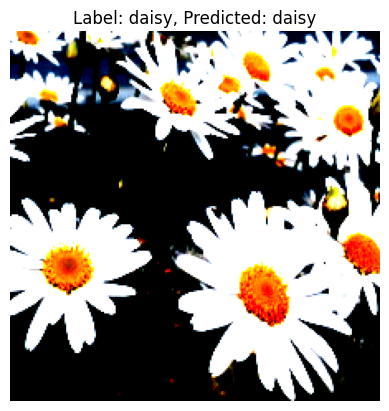

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    # Преобразование to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Получение прогнозов от модели
    yb = model(xb)
    # Выбираем индекс с наибольшей вероятностью
    _, preds  = torch.max(yb, dim=1)
    # Получение метки класса
    return dataset.classes[preds[0].item()]

for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, model)))
  plt.show()

# Практическое задание



В задние представлено логика выполнения с использование tensorflow/keras. Выполнять можно как с использованием tensorflow/keras, так и pytorch.

1. Необходимо обучить предобученную сверточную архитектуру для задач классификации цветов.

В выбранной Вами архитектуре также необходимо **разобраться** с основными её параметрами и принципами работы.

Посмотрите как использовать [модели в PyTorch](https://pytorch.org/vision/stable/models.html) для классификации, выберите одну и используя transfer learning до-обучите модель на классификацию цветов. Чтобы это сделать замените ____ в ячейках ниже на работающий код.

2. Реализовать свою архитектуру, также как в разделе "Сверточная нейросеть с нуля".

3. Сравнить три архитектуры (из раздела "Сверточная нейросеть с нуля", предобученую сверточную архитектуру и свою архитектуру (из п. 2)). Визуализировать полученный результат сравнения.





1. Обучение предобученной сверточной архитектуры для задач классификации цветов

In [ ]:
model = torchvision.models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Функция для заморозки весов модели
def set_parameter_requires_grad(model):
  for param in model.parameters():
    param.requires_grad = False

set_parameter_requires_grad(model) # передайте модель в функцию для "заморозки" градиента

In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.classes)) # Меняем последний слой модели Зачем? Сколькой нужно выходов?

In [ ]:
# Проверим все ли сработало правильно, выведем веса, которые будут обучаться
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

fc.weight
fc.bias


In [ ]:
model.to(device) # Отправляем модель на GPU
optimizer = torch.optim.Adam(params = model.parameters(), lr=lr) # алгоритм оптимизации
loss_track_resnet, accuracy_track_resnet = trainval(model, loaders, optimizer, epochs=10) #обратить внимание на loss_track и accuracy_track

100%|██████████| 104/104 [00:24<00:00,  4.33it/s]


[training] Epoch: 0.00. Loss: 0.97. Accuracy: 64.57% 


100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


[validation] Epoch: 0.00. Loss: 0.57. Accuracy: 82.90% 


100%|██████████| 104/104 [00:21<00:00,  4.88it/s]


[training] Epoch: 1.00. Loss: 0.75. Accuracy: 73.99% 


100%|██████████| 32/32 [00:06<00:00,  4.76it/s]


[validation] Epoch: 1.00. Loss: 0.52. Accuracy: 84.30% 


100%|██████████| 104/104 [00:21<00:00,  4.83it/s]


[training] Epoch: 2.00. Loss: 0.64. Accuracy: 78.07% 


100%|██████████| 32/32 [00:06<00:00,  4.64it/s]


[validation] Epoch: 2.00. Loss: 0.48. Accuracy: 85.30% 


100%|██████████| 104/104 [00:21<00:00,  4.79it/s]


[training] Epoch: 3.00. Loss: 0.57. Accuracy: 80.35% 


100%|██████████| 32/32 [00:06<00:00,  4.59it/s]


[validation] Epoch: 3.00. Loss: 0.46. Accuracy: 85.43% 


100%|██████████| 104/104 [00:21<00:00,  4.94it/s]


[training] Epoch: 4.00. Loss: 0.53. Accuracy: 81.95% 


100%|██████████| 32/32 [00:06<00:00,  4.63it/s]


[validation] Epoch: 4.00. Loss: 0.44. Accuracy: 86.06% 


100%|██████████| 104/104 [00:20<00:00,  4.97it/s]


[training] Epoch: 5.00. Loss: 0.50. Accuracy: 83.20% 


100%|██████████| 32/32 [00:06<00:00,  4.77it/s]


[validation] Epoch: 5.00. Loss: 0.42. Accuracy: 86.38% 


100%|██████████| 104/104 [00:21<00:00,  4.91it/s]


[training] Epoch: 6.00. Loss: 0.47. Accuracy: 84.04% 


100%|██████████| 32/32 [00:07<00:00,  4.55it/s]


[validation] Epoch: 6.00. Loss: 0.41. Accuracy: 86.69% 


100%|██████████| 104/104 [00:20<00:00,  4.99it/s]


[training] Epoch: 7.00. Loss: 0.45. Accuracy: 84.74% 


100%|██████████| 32/32 [00:06<00:00,  4.59it/s]


[validation] Epoch: 7.00. Loss: 0.41. Accuracy: 86.78% 


100%|██████████| 104/104 [00:22<00:00,  4.53it/s]


[training] Epoch: 8.00. Loss: 0.43. Accuracy: 85.24% 


100%|██████████| 32/32 [00:07<00:00,  4.43it/s]


[validation] Epoch: 8.00. Loss: 0.40. Accuracy: 87.00% 


100%|██████████| 104/104 [00:20<00:00,  5.02it/s]


[training] Epoch: 9.00. Loss: 0.42. Accuracy: 85.67% 


100%|██████████| 32/32 [00:07<00:00,  4.45it/s]

[validation] Epoch: 9.00. Loss: 0.39. Accuracy: 87.11% 


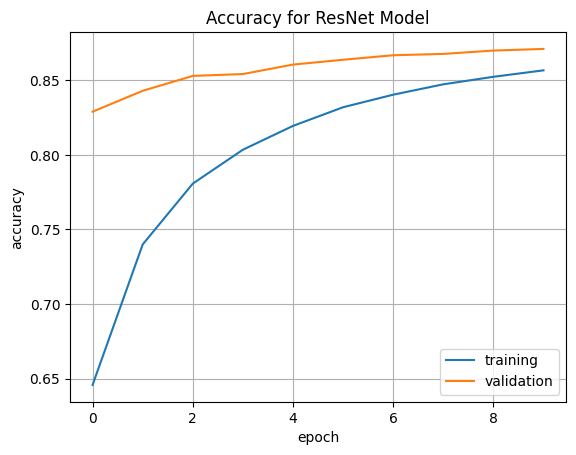

In [ ]:
plt.plot(accuracy_track_resnet['training'], label='training')
plt.plot(accuracy_track_resnet['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Accuracy for ResNet Model')
plt.grid()
plt.legend()

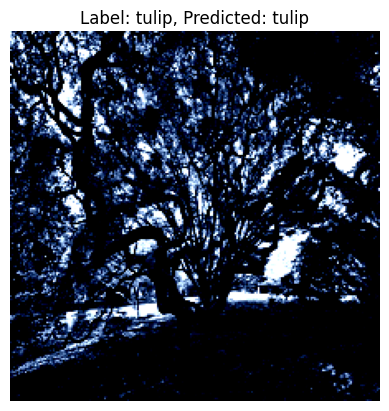

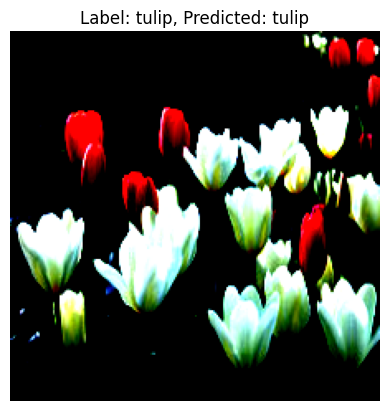

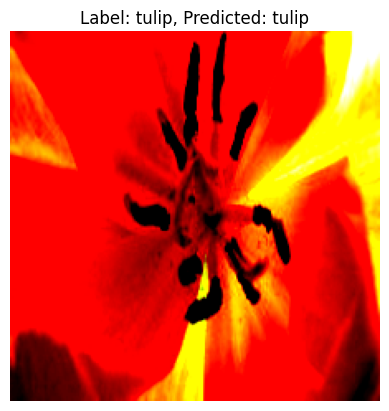

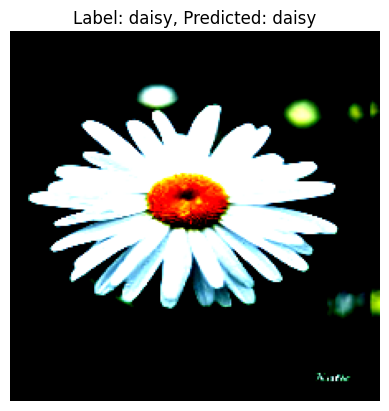

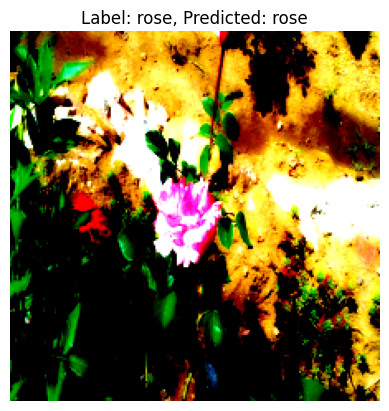

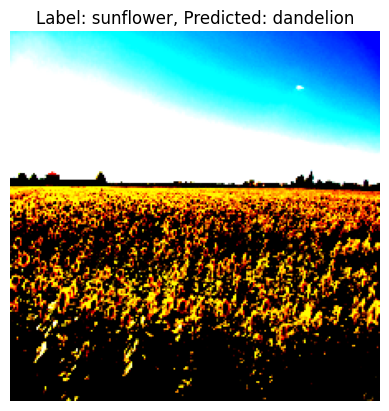

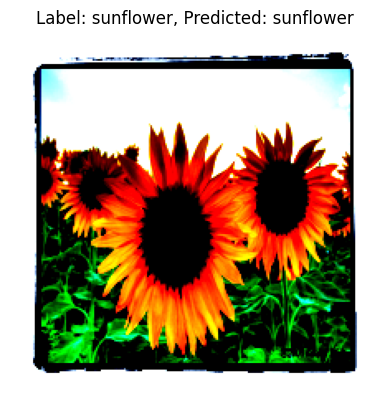

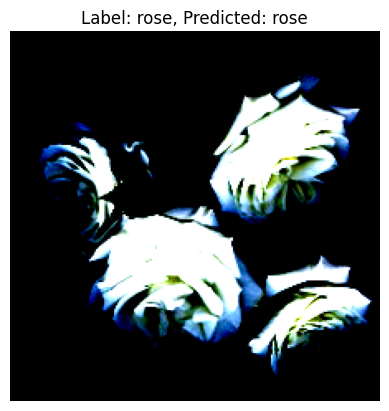

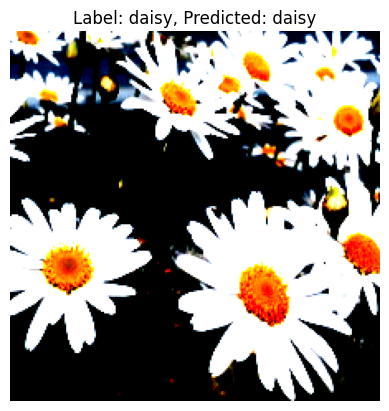

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    xb = img.unsqueeze(0).to(device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, model)))
  plt.show()

По желанию, можно сохранить веса модели.

In [ ]:
weights_fname = '/content/drive/My Drive/data/resnet18_flowers.pth'
torch.save(model.state_dict(), weights_fname)

2. Своя архитектура

In [ ]:
custom_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 5))
custom_model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=50176, out_features=256, bias=True)
  (11): ReLU()
  (12): Linear(in_features=256, out_features=5, bias=True)
)

In [ ]:
optimizer_custom = torch.optim.Adam(params=custom_model.parameters(), lr=lr)
loss_track_custom, accuracy_track_custom = trainval(custom_model, loaders, optimizer_custom, epochs=10)


100%|██████████| 104/104 [00:21<00:00,  4.93it/s]


[training] Epoch: 0.00. Loss: 1.38. Accuracy: 42.31% 


100%|██████████| 32/32 [00:06<00:00,  5.30it/s]


[validation] Epoch: 0.00. Loss: 1.08. Accuracy: 55.30% 


100%|██████████| 104/104 [00:21<00:00,  4.92it/s]


[training] Epoch: 1.00. Loss: 1.22. Accuracy: 50.06% 


100%|██████████| 32/32 [00:05<00:00,  5.42it/s]


[validation] Epoch: 1.00. Loss: 1.07. Accuracy: 55.95% 


100%|██████████| 104/104 [00:21<00:00,  4.87it/s]


[training] Epoch: 2.00. Loss: 1.12. Accuracy: 54.80% 


100%|██████████| 32/32 [00:05<00:00,  5.53it/s]


[validation] Epoch: 2.00. Loss: 1.04. Accuracy: 58.30% 


100%|██████████| 104/104 [00:21<00:00,  4.82it/s]


[training] Epoch: 3.00. Loss: 1.02. Accuracy: 59.10% 


100%|██████████| 32/32 [00:05<00:00,  5.62it/s]


[validation] Epoch: 3.00. Loss: 1.01. Accuracy: 59.78% 


100%|██████████| 104/104 [00:21<00:00,  4.76it/s]


[training] Epoch: 4.00. Loss: 0.92. Accuracy: 63.90% 


100%|██████████| 32/32 [00:05<00:00,  5.53it/s]


[validation] Epoch: 4.00. Loss: 1.02. Accuracy: 60.66% 


100%|██████████| 104/104 [00:21<00:00,  4.87it/s]


[training] Epoch: 5.00. Loss: 0.80. Accuracy: 68.67% 


100%|██████████| 32/32 [00:05<00:00,  5.55it/s]


[validation] Epoch: 5.00. Loss: 1.07. Accuracy: 60.70% 


100%|██████████| 104/104 [00:21<00:00,  4.84it/s]


[training] Epoch: 6.00. Loss: 0.70. Accuracy: 72.76% 


100%|██████████| 32/32 [00:05<00:00,  5.53it/s]


[validation] Epoch: 6.00. Loss: 1.16. Accuracy: 60.80% 


100%|██████████| 104/104 [00:21<00:00,  4.85it/s]


[training] Epoch: 7.00. Loss: 0.62. Accuracy: 75.99% 


100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


[validation] Epoch: 7.00. Loss: 1.24. Accuracy: 61.08% 


100%|██████████| 104/104 [00:21<00:00,  4.82it/s]


[training] Epoch: 8.00. Loss: 0.55. Accuracy: 78.61% 


100%|██████████| 32/32 [00:05<00:00,  5.66it/s]


[validation] Epoch: 8.00. Loss: 1.39. Accuracy: 60.63% 


100%|██████████| 104/104 [00:21<00:00,  4.91it/s]


[training] Epoch: 9.00. Loss: 0.50. Accuracy: 80.62% 


100%|██████████| 32/32 [00:05<00:00,  5.54it/s]

[validation] Epoch: 9.00. Loss: 1.44. Accuracy: 61.02% 


Predictions for Custom CNN Model:


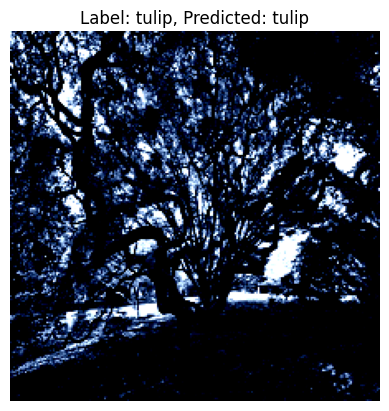

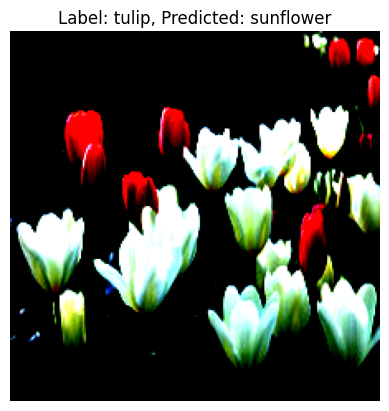

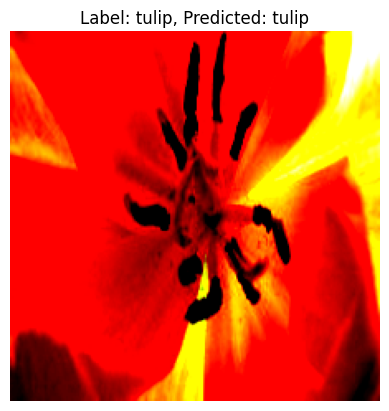

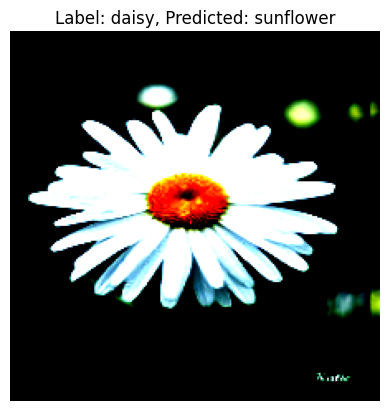

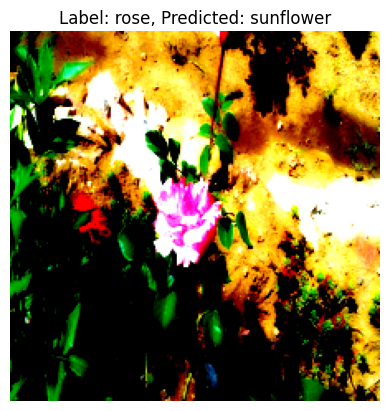

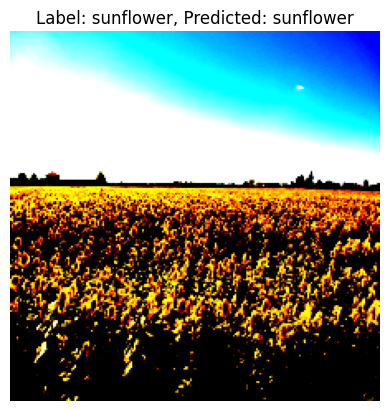

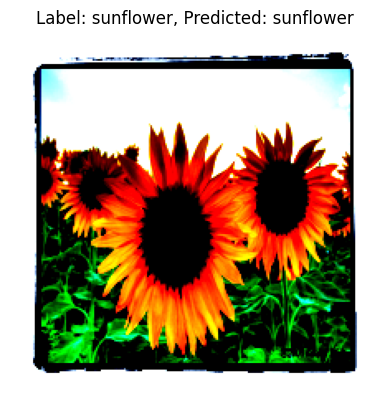

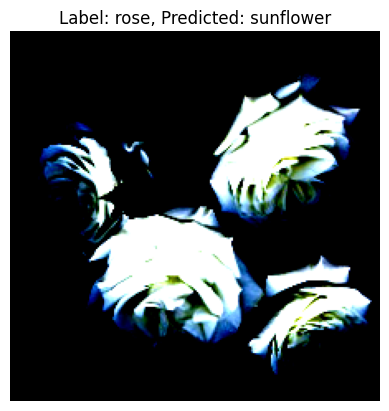

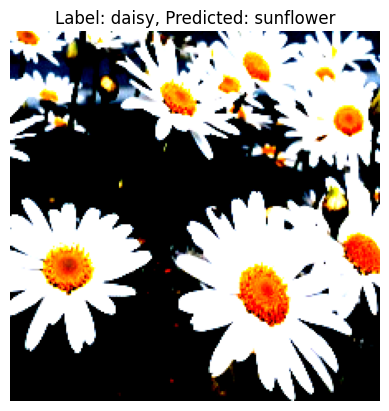

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    xb = img.unsqueeze(0).to(device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

print("Predictions for Custom CNN Model:")
for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, custom_model)))
  plt.show()

3. Сравнение и вузуализация 3-х архитектур

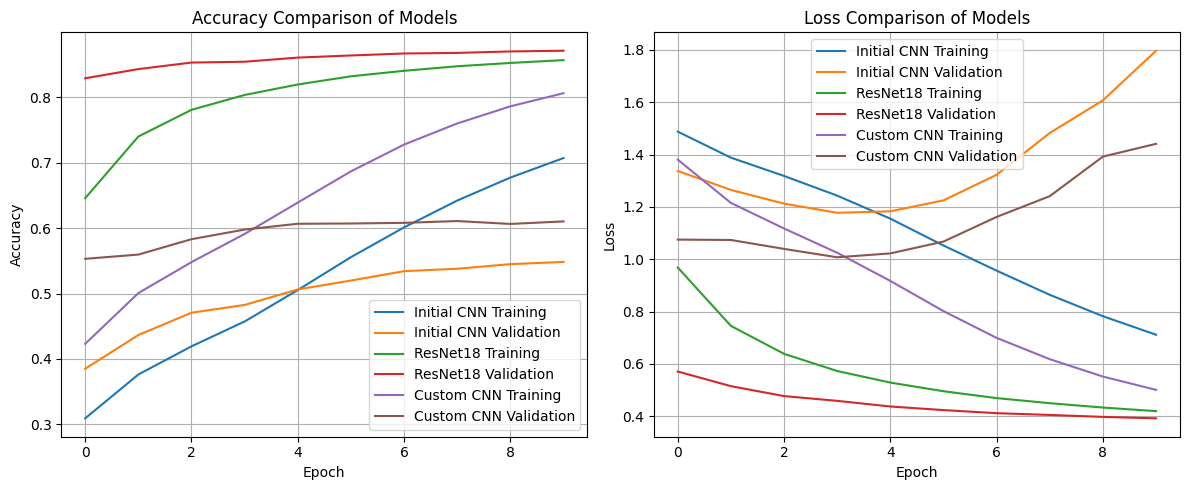

In [ ]:
plt.figure(figsize=(12, 5))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot([t.cpu().numpy() for t in accuracy_track['training']], label='Initial CNN Training')
plt.plot([t.cpu().numpy() for t in accuracy_track['validation']], label='Initial CNN Validation')
plt.plot([t.cpu().numpy() for t in accuracy_track_resnet['training']], label='ResNet18 Training')
plt.plot([t.cpu().numpy() for t in accuracy_track_resnet['validation']], label='ResNet18 Validation')
plt.plot([t.cpu().numpy() for t in accuracy_track_custom['training']], label='Custom CNN Training')
plt.plot([t.cpu().numpy() for t in accuracy_track_custom['validation']], label='Custom CNN Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Accuracy Comparison of Models')
plt.grid()
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(loss_track['training'], label='Initial CNN Training')
plt.plot(loss_track['validation'], label='Initial CNN Validation')
plt.plot(loss_track_resnet['training'], label='ResNet18 Training')
plt.plot(loss_track_resnet['validation'], label='ResNet18 Validation')
plt.plot(loss_track_custom['training'], label='Custom CNN Training')
plt.plot(loss_track_custom['validation'], label='Custom CNN Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss Comparison of Models')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

### Расчет и сравнение метрик качества (Accuracy, Precision, Recall, F1-Score) для всех моделей

In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import torch
import pandas as pd

def evaluate_model_metrics(model, dataloader, device):
    model.eval() # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    with torch.no_grad(): # Disable gradient calculation
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return accuracy, precision, recall, f1

metrics_data = []

# --- Evaluate ResNet18 Model (currently in 'model' variable) ---
print("Evaluating ResNet18 Model...")
resnet_accuracy, resnet_precision, resnet_recall, resnet_f1 = evaluate_model_metrics(model, loaders['validation'], device)
metrics_data.append({
    'Model': 'ResNet18',
    'Accuracy': resnet_accuracy,
    'Precision': resnet_precision,
    'Recall': resnet_recall,
    'F1-Score': resnet_f1
})
print(f"ResNet18 - Accuracy: {resnet_accuracy:.4f}, Precision: {resnet_precision:.4f}, Recall: {resnet_recall:.4f}, F1-Score: {resnet_f1:.4f}")

# --- Evaluate Custom CNN Model ---
print("Evaluating Custom CNN Model...")
custom_cnn_accuracy, custom_cnn_precision, custom_cnn_recall, custom_cnn_f1 = evaluate_model_metrics(custom_model, loaders['validation'], device)
metrics_data.append({
    'Model': 'Custom CNN',
    'Accuracy': custom_cnn_accuracy,
    'Precision': custom_cnn_precision,
    'Recall': custom_cnn_recall,
    'F1-Score': custom_cnn_f1
})
print(f"Custom CNN - Accuracy: {custom_cnn_accuracy:.4f}, Precision: {custom_cnn_precision:.4f}, Recall: {custom_cnn_recall:.4f}, F1-Score: {custom_cnn_f1:.4f}")

# --- Get metrics for Initial CNN (only accuracy available directly from history) ---
# The 'model' variable was overwritten, so we can only get its accuracy from the stored 'accuracy_track'.
# Precision, Recall, F1-Score cannot be computed without the actual trained model object.
initial_cnn_final_accuracy = accuracy_track['validation'][-1] if accuracy_track['validation'] else 0
metrics_data.append({
    'Model': 'Initial CNN',
    'Accuracy': initial_cnn_final_accuracy,
    'Precision': 'N/A',
    'Recall': 'N/A',
    'F1-Score': 'N/A'
})
print(f"Initial CNN (from training history) - Accuracy: {initial_cnn_final_accuracy:.4f}, Precision: N/A, Recall: N/A, F1-Score: N/A")

# --- Display results in a table ---
df_metrics = pd.DataFrame(metrics_data)
display(df_metrics)


Evaluating ResNet18 Model...


NameError: name 'model' is not defined

## Вопросы.
Добавте описание архитектуры выбранной Вами предобученой сверточной нейронной сети.

Как работает выбранная вами модель сверточной нейронной сети? Какие параметры?

В чем основные отличия между сверточной нейронной сетью и "обычной" полносвязной нейронной сетью?

Что такое transfer learning? Что такое предобучена нейронная сеть?

Что такое функция для заморозки весов модели?

Как работает блок "Сверточная нейросеть с нуля"? Описать сверточный и пулинговый слой.